# Data download

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lux 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/olist_order_payments_dataset.csv
./data/olist_sellers_dataset.csv
./data/olist_order_reviews_dataset.csv
./data/olist_order_items_dataset.csv
./data/olist_orders_dataset.csv
./data/olist_geolocation_dataset.csv
./data/olist_products_dataset.csv
./data/olist_customers_dataset.csv
./data/product_category_name_translation.csv


In [2]:
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
items = pd.read_csv("./data/olist_order_items_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")

## Merge datasets

In [3]:
datasets = [customers, sellers, reviews, items, products, geolocation, category_name_translation, orders, order_payments]

In [4]:
df = orders.merge(items, on="order_id").merge(products, on = "product_id").merge(sellers, on="seller_id").merge(customers, on="customer_id")

In [5]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

# Data cleaning

In [6]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df['expected_delivery_timedelta'] = pd.to_numeric(df['order_estimated_delivery_date']- df["order_purchase_timestamp"])
df['delivery_time'] = pd.to_numeric(df["order_delivered_customer_date"] - df['order_purchase_timestamp'])

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [16]:
#df.drop(["expected_delivery_timedelta"], axis = 1, inplace=True)

In [7]:
df

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/vislib/altair/Histogram.py:47: RuntimeWarning:overflow encountered in long_scalars


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [8]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

## Detecting outliers in numerical data

In [9]:
unique_orders_count = df.groupby(["customer_id"])["order_id"].count() # Count unique orders
nof_moest_popular_sales = df.groupby(["customer_id"])["seller_id"].agg(lambda x:x.value_counts()[0]) # Number of orders from most popular sellers
max_sale = df.groupby(["customer_id"])["price"].max() # Most money spent on single order
median_sale = df.groupby(["customer_id"])["price"].median() # Median money spent on orders
sum_sale = df.groupby(["customer_id"])["price"].sum() # Median money spent on orders

median_volume = df.groupby(["customer_id"])["product_volume"].median() # Median volume of products in orders
max_volume = df.groupby(["customer_id"])["product_volume"].max() # Median money spent on orders

average_delivery_time = df.groupby(["customer_id"])["delivery_time"].max() # Average delivery time
average_expected_delivery_time = df.groupby(["customer_id"])["expected_delivery_timedelta"].max() # Average delivery time


unique_orders_count.name = "unique_orders_count"
nof_moest_popular_sales.name = "nof_moest_popular_sales"
max_sale.name = "max_sale"
median_sale.name = "median_sale"
sum_sale.name = "sum_sale"
median_volume.name = "median_volume"
average_delivery_time.name = "average_delivery_time"
average_expected_delivery_time.name = "average_expected_delivery_time"

In [10]:
customers2 = customers.set_index("customer_id")

In [11]:
customers2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [12]:
df2 = customers2.join([unique_orders_count, nof_moest_popular_sales, max_sale, median_sale, sum_sale, median_volume, average_delivery_time,average_expected_delivery_time],  how="outer")

In [13]:
df2[df2["unique_orders_count"] > 1]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [14]:
cat_attributes = ["customer_city", "customer_state"]
num_attributes = ["unique_orders_count", "nof_moest_popular_sales", "max_sale", "median_sale", "sum_sale", "median_volume", "average_delivery_time","average_expected_delivery_time"]

In [15]:
df2['average_expected_delivery_time'] = df2['average_expected_delivery_time']
df2['average_delivery_time'] = df2['average_delivery_time']

In [16]:
df2.fillna(df2.mean(), inplace=True)

In [17]:
df2.info()

<class 'lux.core.frame.LuxDataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              99441 non-null  object 
 1   customer_zip_code_prefix        99441 non-null  int64  
 2   customer_city                   99441 non-null  object 
 3   customer_state                  99441 non-null  object 
 4   unique_orders_count             99441 non-null  float64
 5   nof_moest_popular_sales         99441 non-null  float64
 6   max_sale                        99441 non-null  float64
 7   median_sale                     99441 non-null  float64
 8   sum_sale                        99441 non-null  float64
 9   median_volume                   99441 non-null  float64
 10  average_delivery_time           99441 non-null  float64
 11  average_expected_delivery_time  99441 no

In [50]:
df2.groupby("customer_city")["customer_state"].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [51]:
groupby_col="customer_city"


In [59]:
other_countes = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[21:,:].reset_index()[groupby_col].array

In [70]:
df2.loc[df2.customer_city.isin(other_countes), "customer_city"] = "other"

In [74]:
df2.customer_city.nunique()

22

In [75]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df2)
df_prepared

<99441x57 sparse matrix of type '<class 'numpy.float64'>'
	with 991310 stored elements in Compressed Sparse Row format>

In [76]:
df3 = df_prepared.toarray()

In [106]:
len(num_attributes)

8

In [77]:
import lux
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# UMAP

In [78]:
import umap

In [79]:
import umap.plot

In [111]:
mapper = umap.UMAP(densmap=True).fit(df3[:,:8])

<AxesSubplot:>

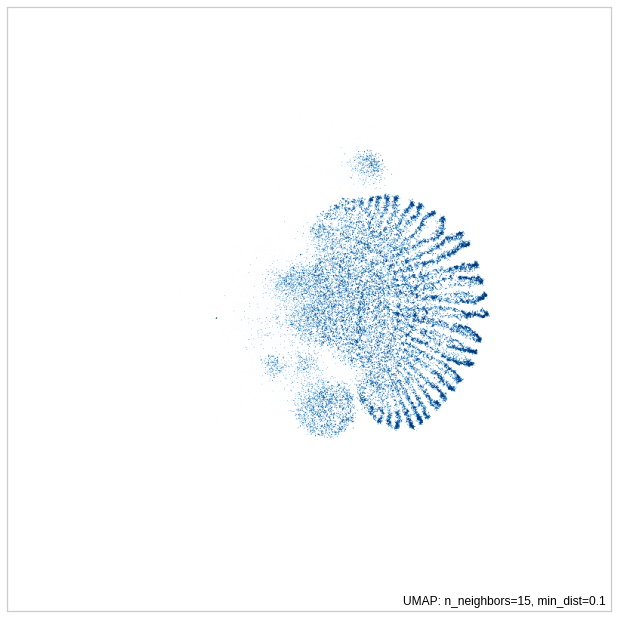

In [112]:
umap.plot.points(mapper)

In [83]:
mapper2 = umap.UMAP(densmap=True).fit(df3[np.random.choice(df3.shape[0], 10000, replace=False)])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

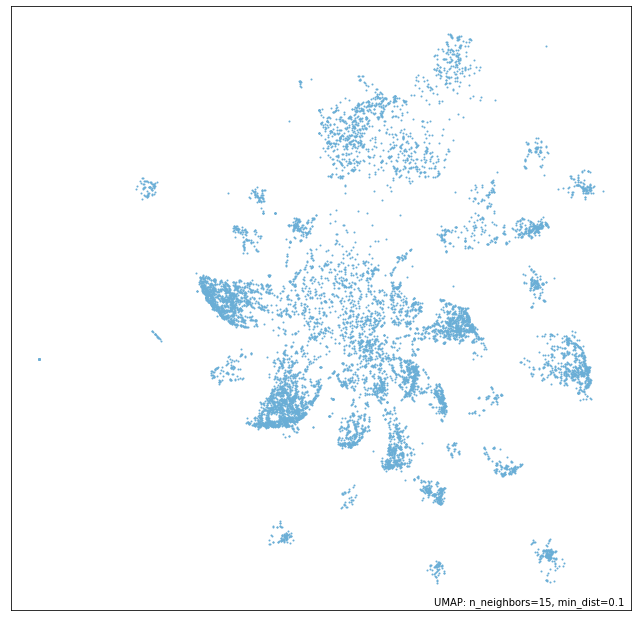

In [84]:
umap.plot.points(mapper2)

In [85]:
df3.data

In [86]:
df3.shape

(99441, 57)

In [87]:
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# KMEANS

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning:No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning


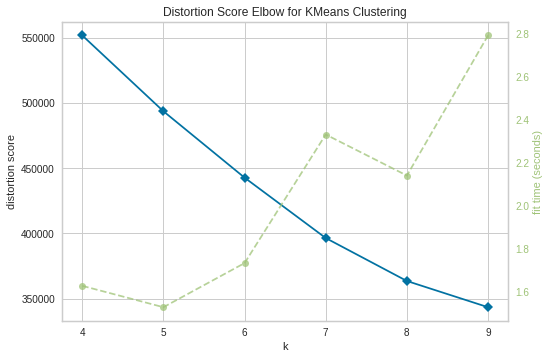

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(4,10), timings=True)
visualizer.fit(df3)
visualizer.show()

In [88]:
from sklearn.cluster import KMeans
X = df3
kmeans = KMeans(n_clusters=6, random_state=0, copy_x=False, precompute_distances=False).fit(X)

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:786: FutureWarning:'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect


In [89]:
kmeans.labels_

array([2, 2, 0, ..., 5, 2, 0], dtype=int32)

<AxesSubplot:>

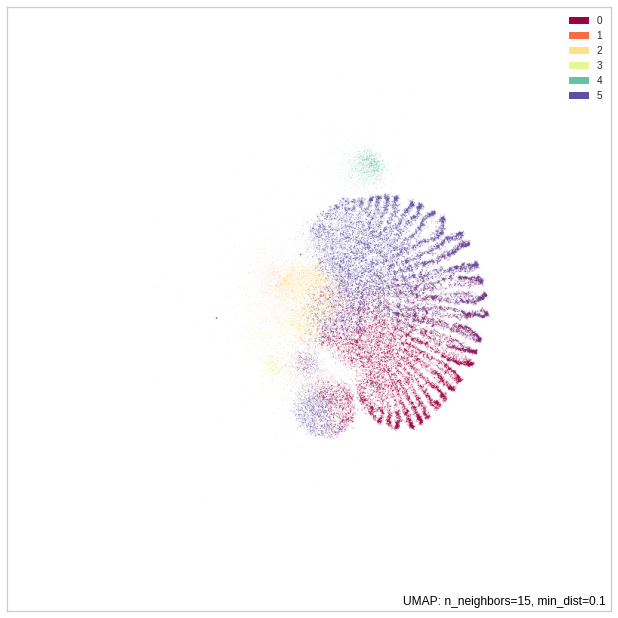

In [113]:
umap.plot.points(mapper, labels=kmeans.labels_)

In [120]:
points = mapper.embedding_

In [121]:
points[:,0]

array([ 0.03307327,  0.20156178,  3.5333304 , ..., 20.976109  ,
       -3.4610434 , 22.301939  ], dtype=float32)

In [122]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<AxesSubplot:>

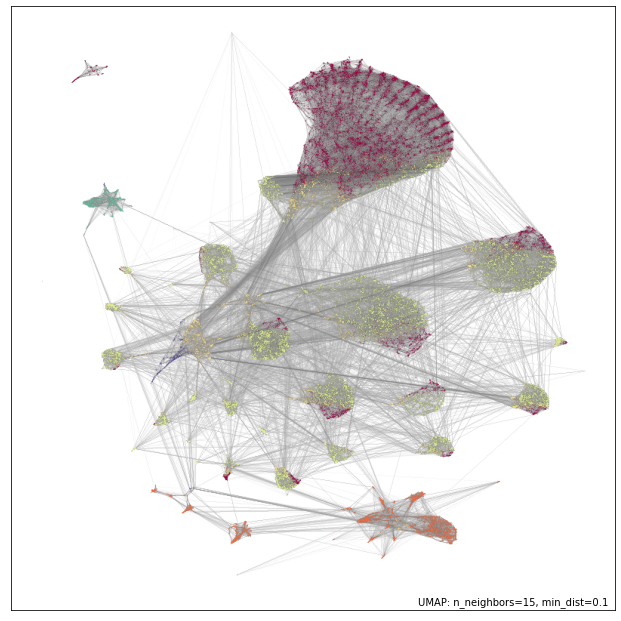

In [38]:
umap.plot.connectivity(mapper, show_points=True, labels=kmeans.labels_)

In [94]:
import seaborn as sns

In [95]:
points

array([[ 8.679784 ,  1.1789019],
       [12.033252 , 10.301234 ],
       [ 6.645532 , 15.290601 ],
       ...,
       [ 2.2625647, -5.1034546],
       [ 6.5970182, -0.4877708],
       [ 1.0386804, 13.518486 ]], dtype=float32)

In [116]:
df2["x"] = points[:,0]
df2["y"] = points[:,1]

In [97]:
df2['y']

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [98]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

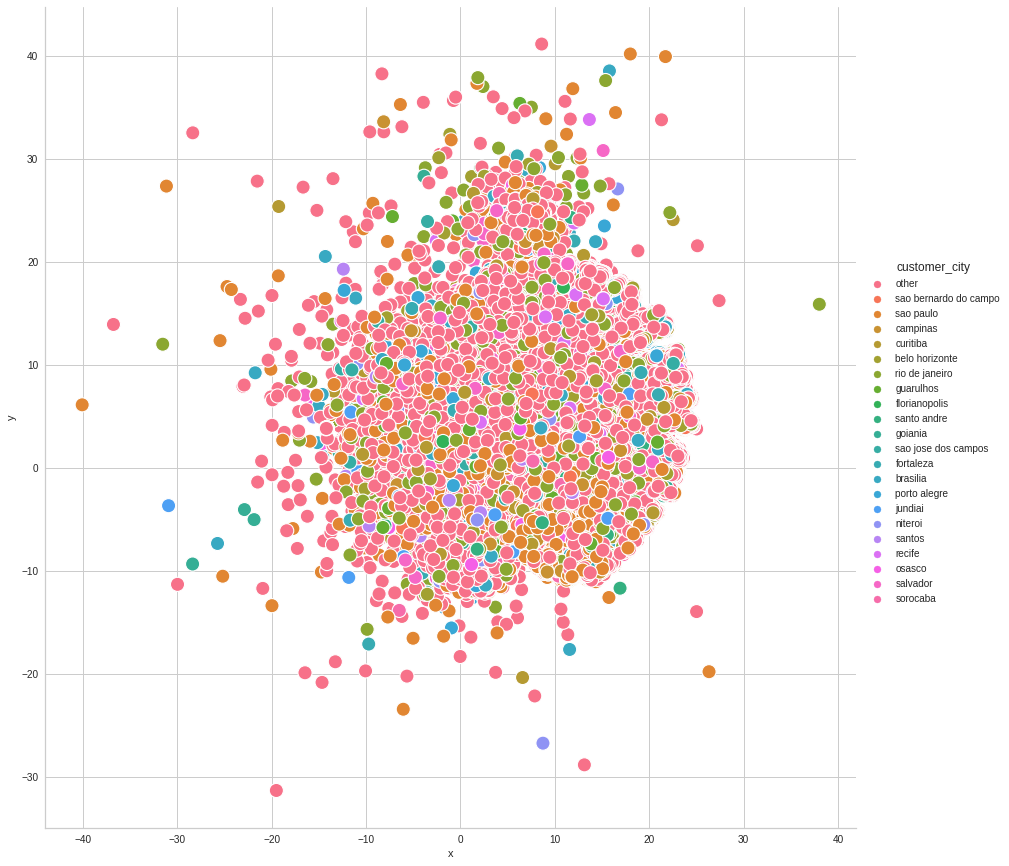

In [119]:
countries = df2.groupby('customer_city').count().sort_values('customer_state', ascending=False).iloc[0:10,:].reset_index()['customer_city'].array
sns.relplot(
    data = df2.loc[df2['customer_city'].isin(countries)],
    x = "x",
    y = "y",
    hue = 'customer_city',
    height = 12,
    s=200)

In [ ]:
sns.scatterplot(x="x", y="y", data=df2[], hue="customer_city")

In [49]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y'],
      dtype='object')

In [100]:
smapper = umap.UMAP().fit_transform(X, kmeans.labels_)

<AxesSubplot:>

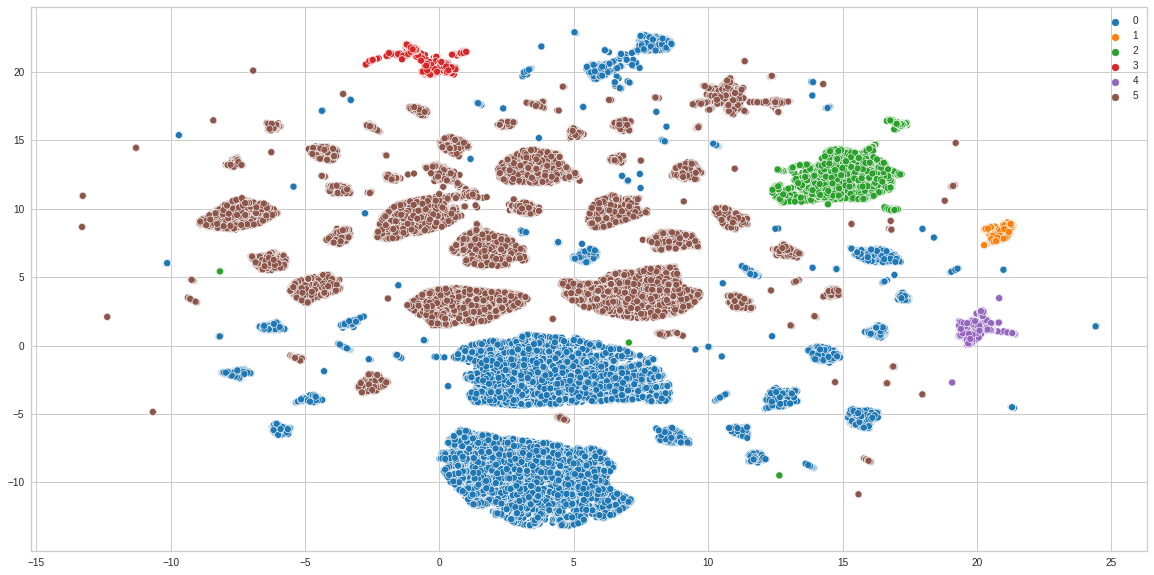

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=smapper[:,0], y=smapper[:,1], hue=kmeans.labels_, palette=sns.color_palette("tab10", 6), ax=ax)

In [71]:
df2['x1'] = smapper[:,0]
df2['y1'] = smapper[:,1]

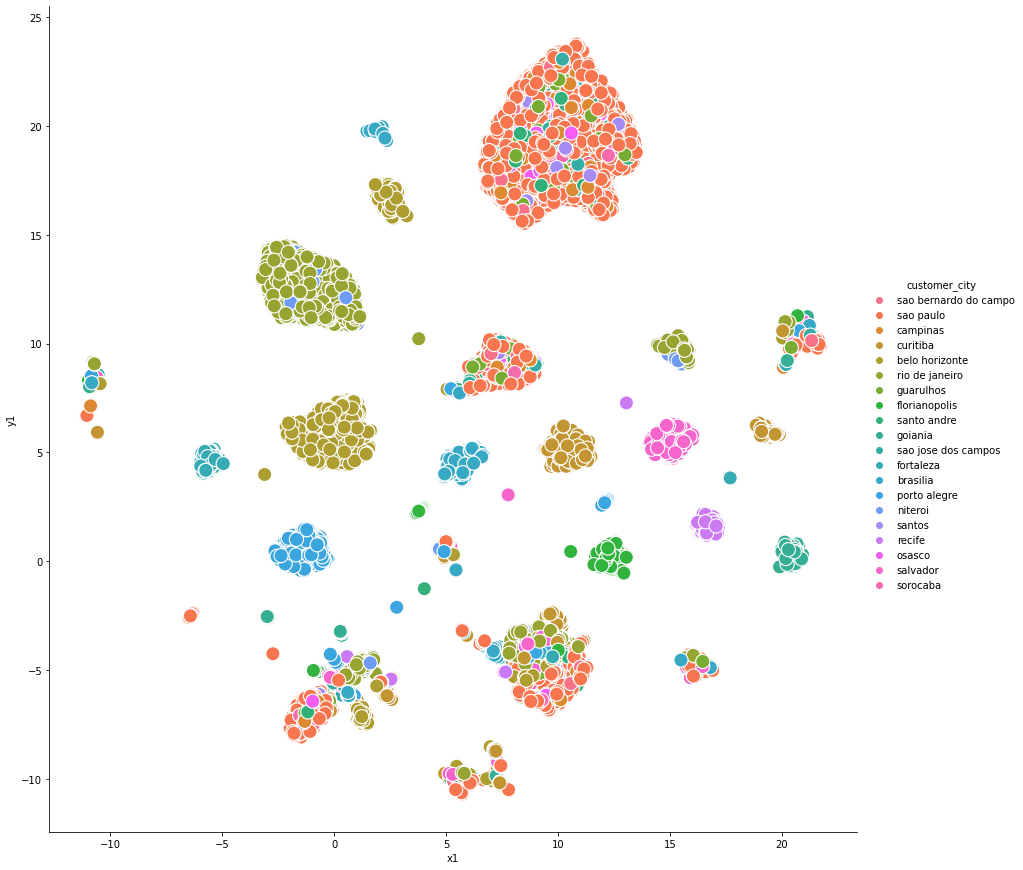

In [74]:
groupby_col="customer_city"

countries = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[0:20,:].reset_index()[groupby_col].array

sns.relplot(
    data = df2.loc[df2[groupby_col].isin(countries)],
    x = "x1",
    y = "y1",
    hue = groupby_col,
    height = 12,
    s=200)

In [76]:
df2.loc[df2[groupby_col].isin(countries)]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [125]:
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [124]:
import sklearn

In [126]:
outlier_scores

array([1, 1, 1, ..., 1, 1, 1])

In [132]:
df2['outlier'] = outlier_scores

In [133]:
df2.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

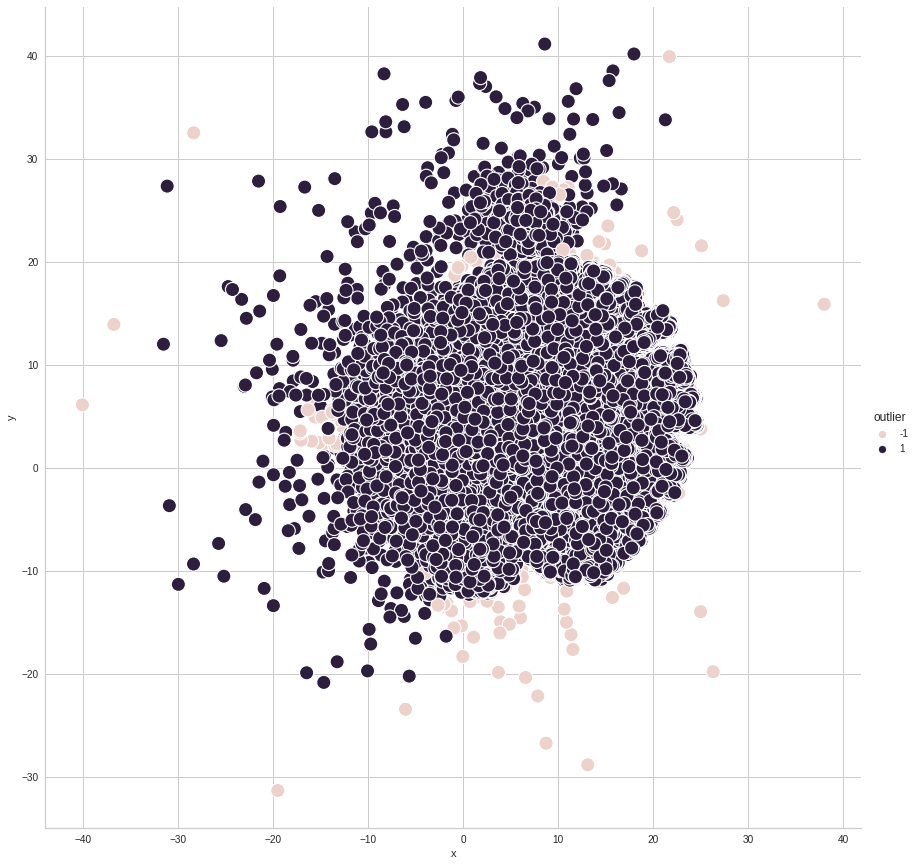

In [135]:
sns.relplot(
    data = df2,
    x = "x",
    y = "y",
    hue = "outlier",
    height = 12,
    s=200)

In [138]:
df.info(0)

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [169]:
df4 = df.merge(df2, on="customer_unique_id")

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='product_width_cm'>

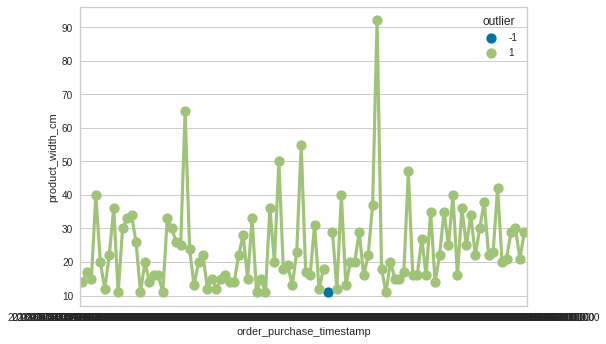

In [168]:
sns.pointplot(x="order_purchase_timestamp", y="product_width_cm", data=df4.sample(100), hue='outlier')

<AxesSubplot:xlabel='price'>

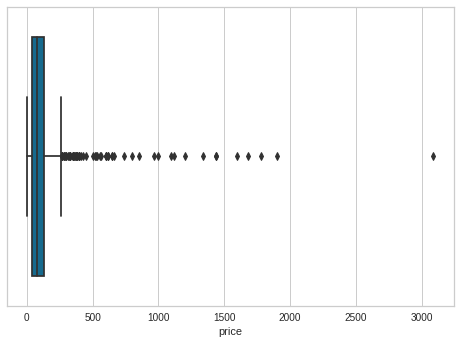

In [148]:
sns.boxplot(x="price", data=df.sample(1000))

<AxesSubplot:xlabel='product_volume'>

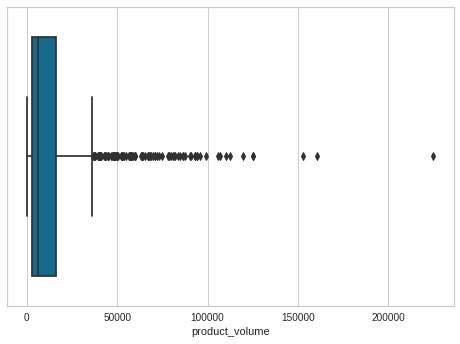

In [147]:
sns.boxplot(x="product_volume", data=df.sample(1000))